# Theoretical Framework with a Poisson Process

In [27]:
# Plot the theoretical and empirical distributions
import numpy as np
def proportional_allocation_error(rate, dp, dg):
    """
    Calculate the mean and variance of the proportional allocation error.
    """
    beta = np.floor(dp/dg)
    mean = np.zeros(max(len(dp),len(dg)))
    var = rate*((1+2*beta)*dp - beta*(beta+1)*dg - (dp**2)/dg)
    return mean, var
def centroid_allocation_error(rate, dp, dg):
    """
    Calculate the mean and variance of the centroid allocation error.
    """
    centroid_overlap = np.floor(dp/dg + 1/2)*dg - dp
    effective_rate = rate * centroid_overlap
    N = len(effective_rate)
    mean = effective_rate
    var = np.abs(effective_rate)
    return mean, var

N = 1000
# dg = np.linspace(0.01, 0.99, N)
# dg = np.logspace(-3, -0.01, N)
dg = np.logspace(-3, -0.01, N)
dp = 0.5*np.ones(N)
ratio = dp / dg
rate = 100
mean_centroid, var_centroid = centroid_allocation_error(rate, dp, dg)
mean_proportional, var_proportional = proportional_allocation_error(rate, dp, dg)


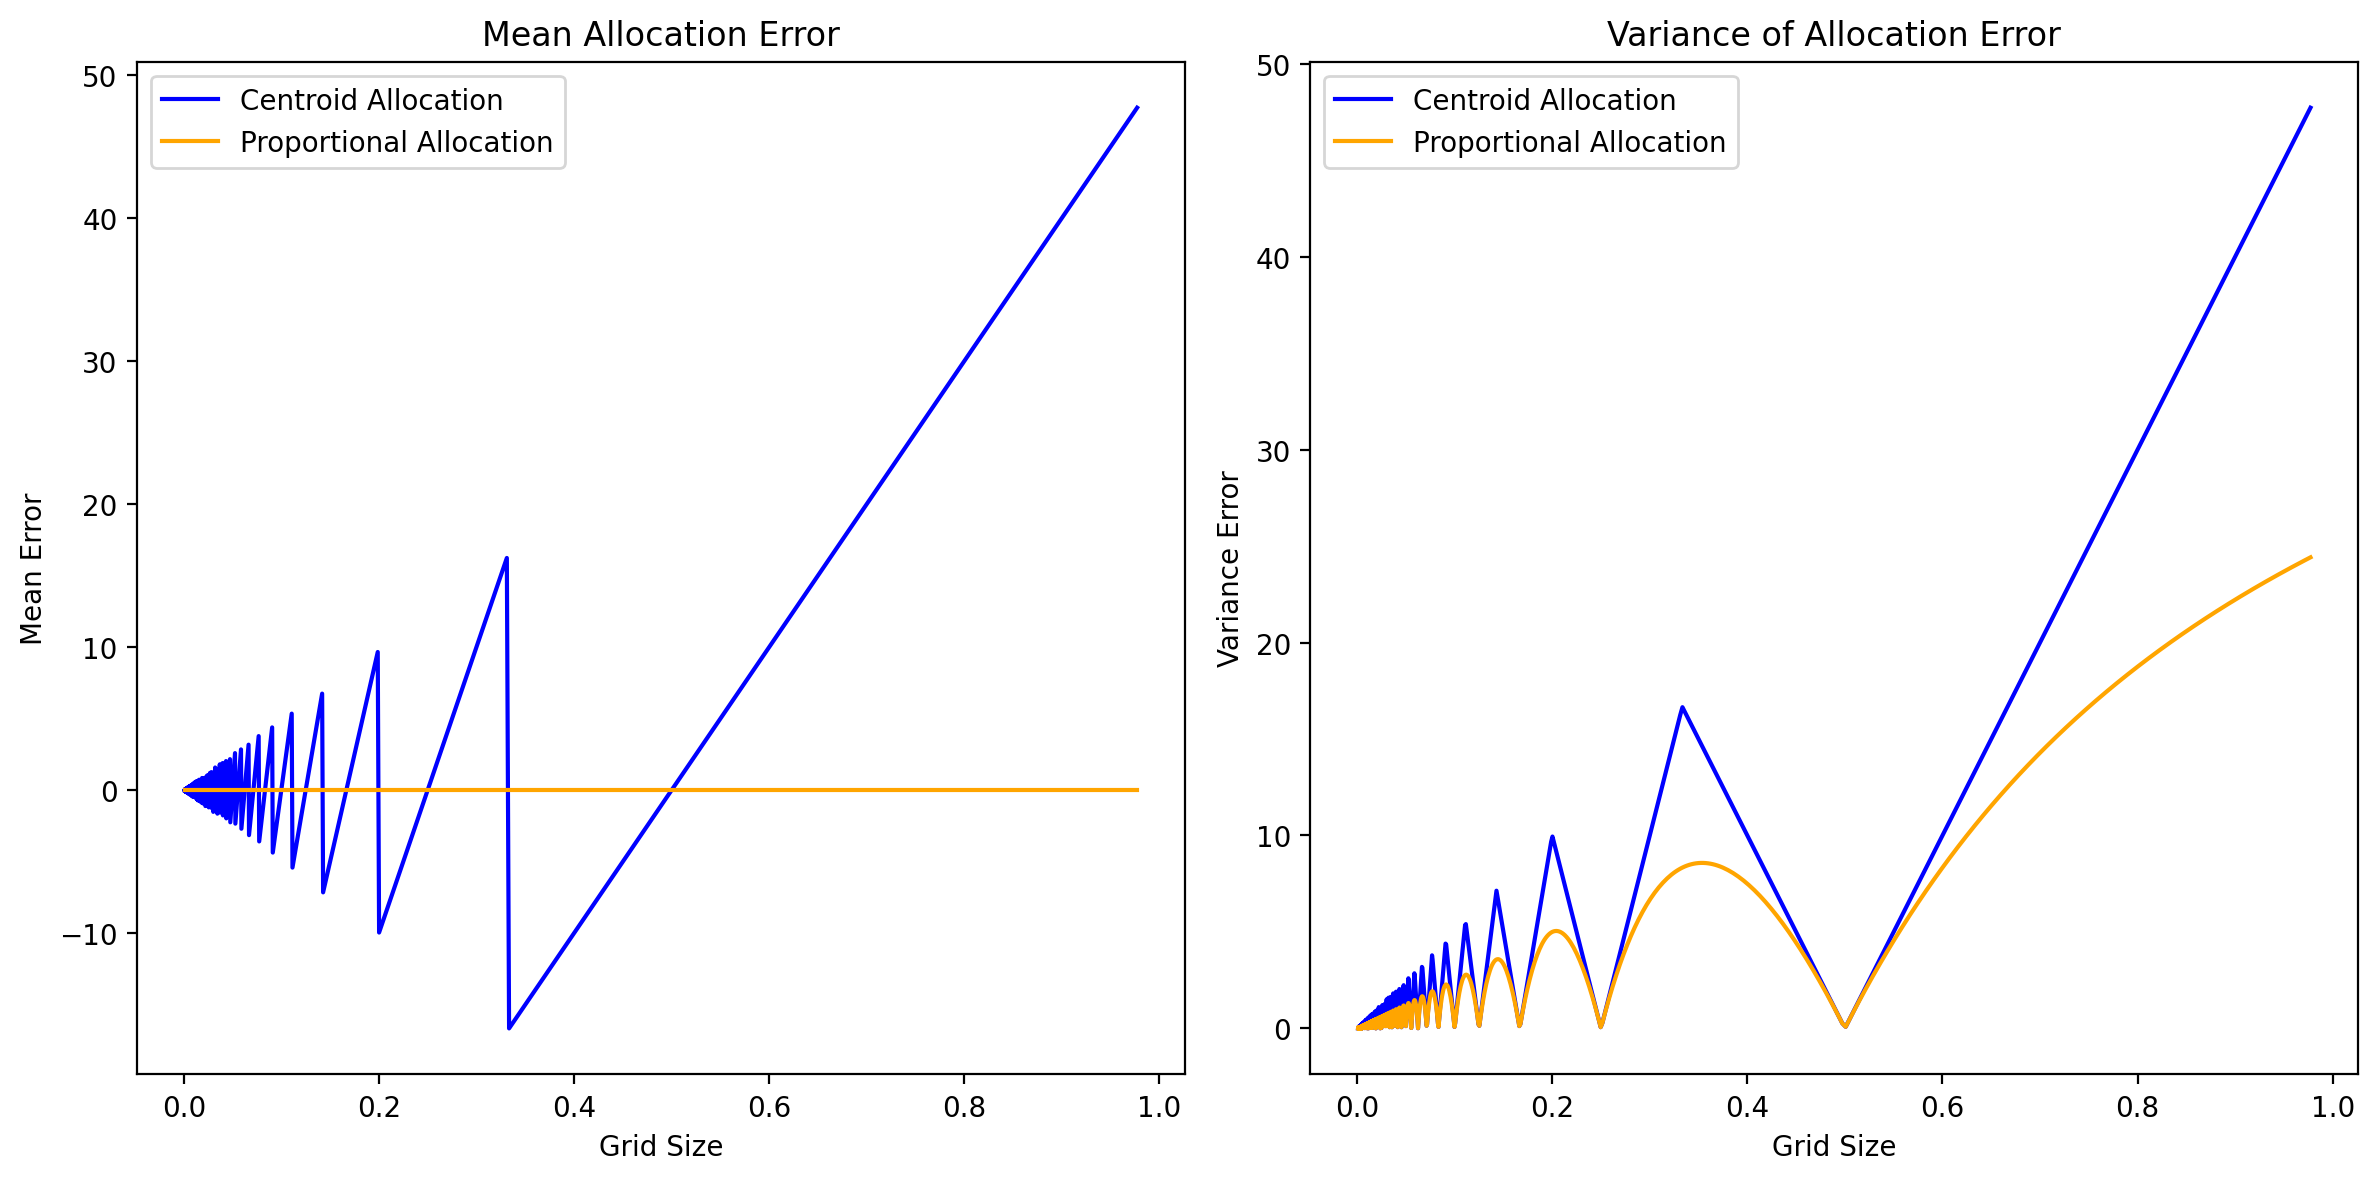

In [28]:
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(dg, mean_centroid, label='Centroid Allocation', color='blue')
ax[0].plot(dg, mean_proportional, label='Proportional Allocation', color='orange')
ax[0].set_title('Mean Allocation Error')
ax[0].set_xlabel('Grid Size')
ax[0].set_ylabel('Mean Error')
ax[0].legend()
ax[1].plot(dg, var_centroid, label='Centroid Allocation', color='blue')
ax[1].plot(dg, var_proportional, label='Proportional Allocation', color='orange')
ax[1].set_title('Variance of Allocation Error')
ax[1].set_xlabel('Grid Size')
ax[1].set_ylabel('Variance Error')
ax[1].legend()
plt.tight_layout()
plt.show()

# Empirical evaluation of the Poisson process

In [29]:
# Create Sample Data
import numpy as np

def get_samples(rate):
    """
    Generate sample data where the number of samples are Poisson distributed 
    and the values are uniformly distributed on [0,1].
    """
    s = np.random.poisson(rate)
    return np.random.rand(s)

# Create gridded data using histogram
def create_gridded_data(data, grid_size):
    """
    Create gridded data using histogram.
    """
    bins = np.arange(0, 1 + grid_size, grid_size)  # Create bins from 0 to 1 with specified grid size
    hist, bin_edges = np.histogram(data, bins=bins)
    return hist, bin_edges

# Create the actual value that falls within the range
def get_actual_value(data, width):
    """
    Calculate the actual value of the data within the specified width.
    """
    return len(data[data <= width])

# Estimate the value using centroid allocation
def centroid_allocation_estimate(count, edges, polygon_width):
    """
    Estimate the value using centroid allocation.
    """
    centers = (edges[:-1] + edges[1:]) / 2
    return sum(count[centers <= polygon_width])

# Estimate the value using proportional allocation
def proportional_allocation_estimate(count, edges, polygon_width):
    """
    Estimate the value using proportional allocation.
    """
    grid_width = edges[1] - edges[0]
    if grid_width < polygon_width:
        edge_right = edges[1:]
        edge_max = max(edge_right[edge_right <= polygon_width])
        edge_index = np.where(edge_right == edge_max)[0][0]+1
        fraction_grid = (polygon_width - edge_max) / grid_width
        return np.sum(count[:edge_index]) + count[edge_index] * fraction_grid
    else: # Just one grid cell, the first one
        return count[0] * (polygon_width / grid_width)

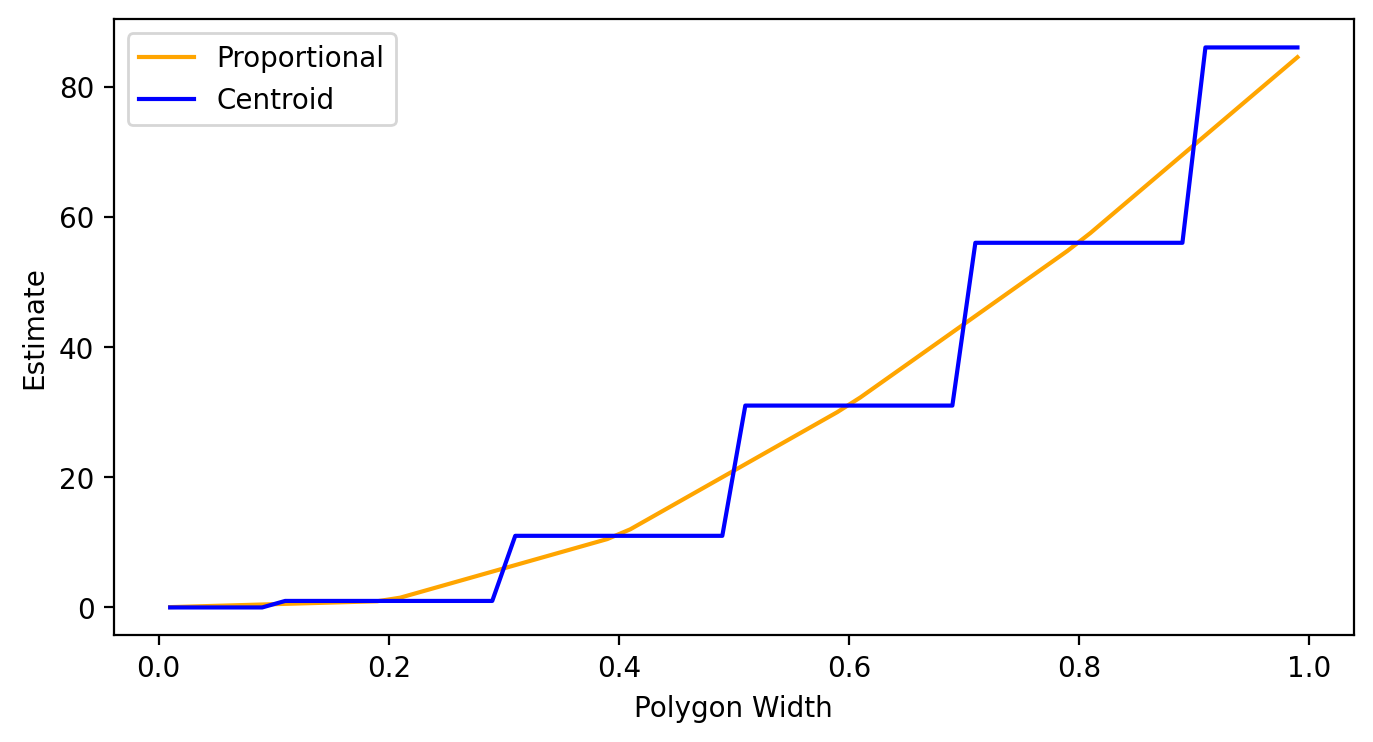

In [30]:
# Run tests for each of the major functions

def test_get_actual_value():
    """
    Test the get_actual_value function.
    """
    data = np.array([0.15, 0.21, 0.29, 0.43, 0.53, 0.67, 0.75, 0.85, 0.95])
    width = 0.3
    result = get_actual_value(data, width)
    assert result == 3, f"Expected 3, but got {result}"
    
def test_proportional_allocation_estimate():
    """
    Test the proportional_allocation_estimate function.
    """
    count1 = np.array([2, 3, 5])
    edges1 = np.array([0.0, 0.2, 0.4, 0.6])
    polygon_width1 = 0.3
    result1 = proportional_allocation_estimate(count1, edges1, polygon_width1)
    assert np.isclose(result1, 3.5), f"Expected 3.5, but got {result1}"
    
    count2 = np.array([2, 3, 5])
    edges2 = np.array([0.0, 0.2, 0.4, 0.6])
    polygon_width2 = 0.1
    result2 = proportional_allocation_estimate(count2, edges2, polygon_width2)
    assert np.isclose(result2,1), f"Expected 1, but got {result2}"
    
    count3 = np.array([2, 3, 5])
    edges3 = np.array([0.0, 0.2, 0.4, 0.6])
    polygon_width3 = 0.25
    result3 = proportional_allocation_estimate(count3, edges3, polygon_width3)
    truth = 2 + (3 * (0.25 - 0.2) / 0.2)
    assert np.isclose(result3, truth), f"Expected {truth}, but got {result3}"

def test_centroid_allocation_estimate():
    """
    Test the centroid_allocation_estimate function.
    """
    count1 = np.array([2, 3, 5])
    edges1 = np.array([0.0, 0.2, 0.4, 0.6])
    polygon_width1 = 0.25
    result1 = centroid_allocation_estimate(count1, edges1, polygon_width1)
    assert np.isclose(result1,2), f"Expected 2, but got {result1}"
    
    count2 = np.array([2, 3, 5])
    edges2 = np.array([0.0, 0.2, 0.4, 0.6])
    polygon_width2 = 0.35
    result2 = centroid_allocation_estimate(count2, edges2, polygon_width2)
    assert np.isclose(result2, 5), f"Expected 5, but got {result2}"

def test_proportional_allocation_estimate2():
    """
    Test the proportional_allocation_estimate function with a different case.
    """
    dp = np.linspace(0.01, 0.99, 50)
    count1 = np.array([1, 10, 20, 25, 30])
    edges1 = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    tot_proportional = []
    tot_centroid = []
    for polygon_width in dp:
        tot_proportional.append(proportional_allocation_estimate(count1, edges1, polygon_width))
        tot_centroid.append(centroid_allocation_estimate(count1, edges1, polygon_width))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(dp, tot_proportional, label="Proportional" , color='orange')
    ax.plot(dp, tot_centroid, label="Centroid" , color='blue')
    ax.set_xlabel('Polygon Width')
    ax.set_ylabel('Estimate')
    ax.legend()
    

test_get_actual_value()
test_proportional_allocation_estimate()
test_centroid_allocation_estimate()
test_proportional_allocation_estimate2()

In [31]:
# Run many iterations to get a distribution of the estimates
trials = 1000
mean_estimate_centroid = []
var_estimate_centroid = []
mean_estimate_proportional = []
var_estimate_proportional = []
for grid_width, polygon_width in zip(dg, dp):
    errors_centroid = []
    errors_proportional = []
    
    for _ in range(trials):
        data = get_samples(rate)
        count, edges = create_gridded_data(data, grid_width)
        actual_value = get_actual_value(data, polygon_width)
        estimate_centroid = centroid_allocation_estimate(count, edges, polygon_width)
        estimate_proportional = proportional_allocation_estimate(count, edges, polygon_width)
        errors_centroid.append(estimate_centroid - actual_value)
        errors_proportional.append(estimate_proportional - actual_value)

    # Calculate mean and variance of the estimates
    mean_estimate_centroid.append(np.mean(errors_centroid))
    var_estimate_centroid.append(np.var(errors_centroid))
    mean_estimate_proportional.append(np.mean(errors_proportional))
    var_estimate_proportional.append(np.var(errors_proportional))

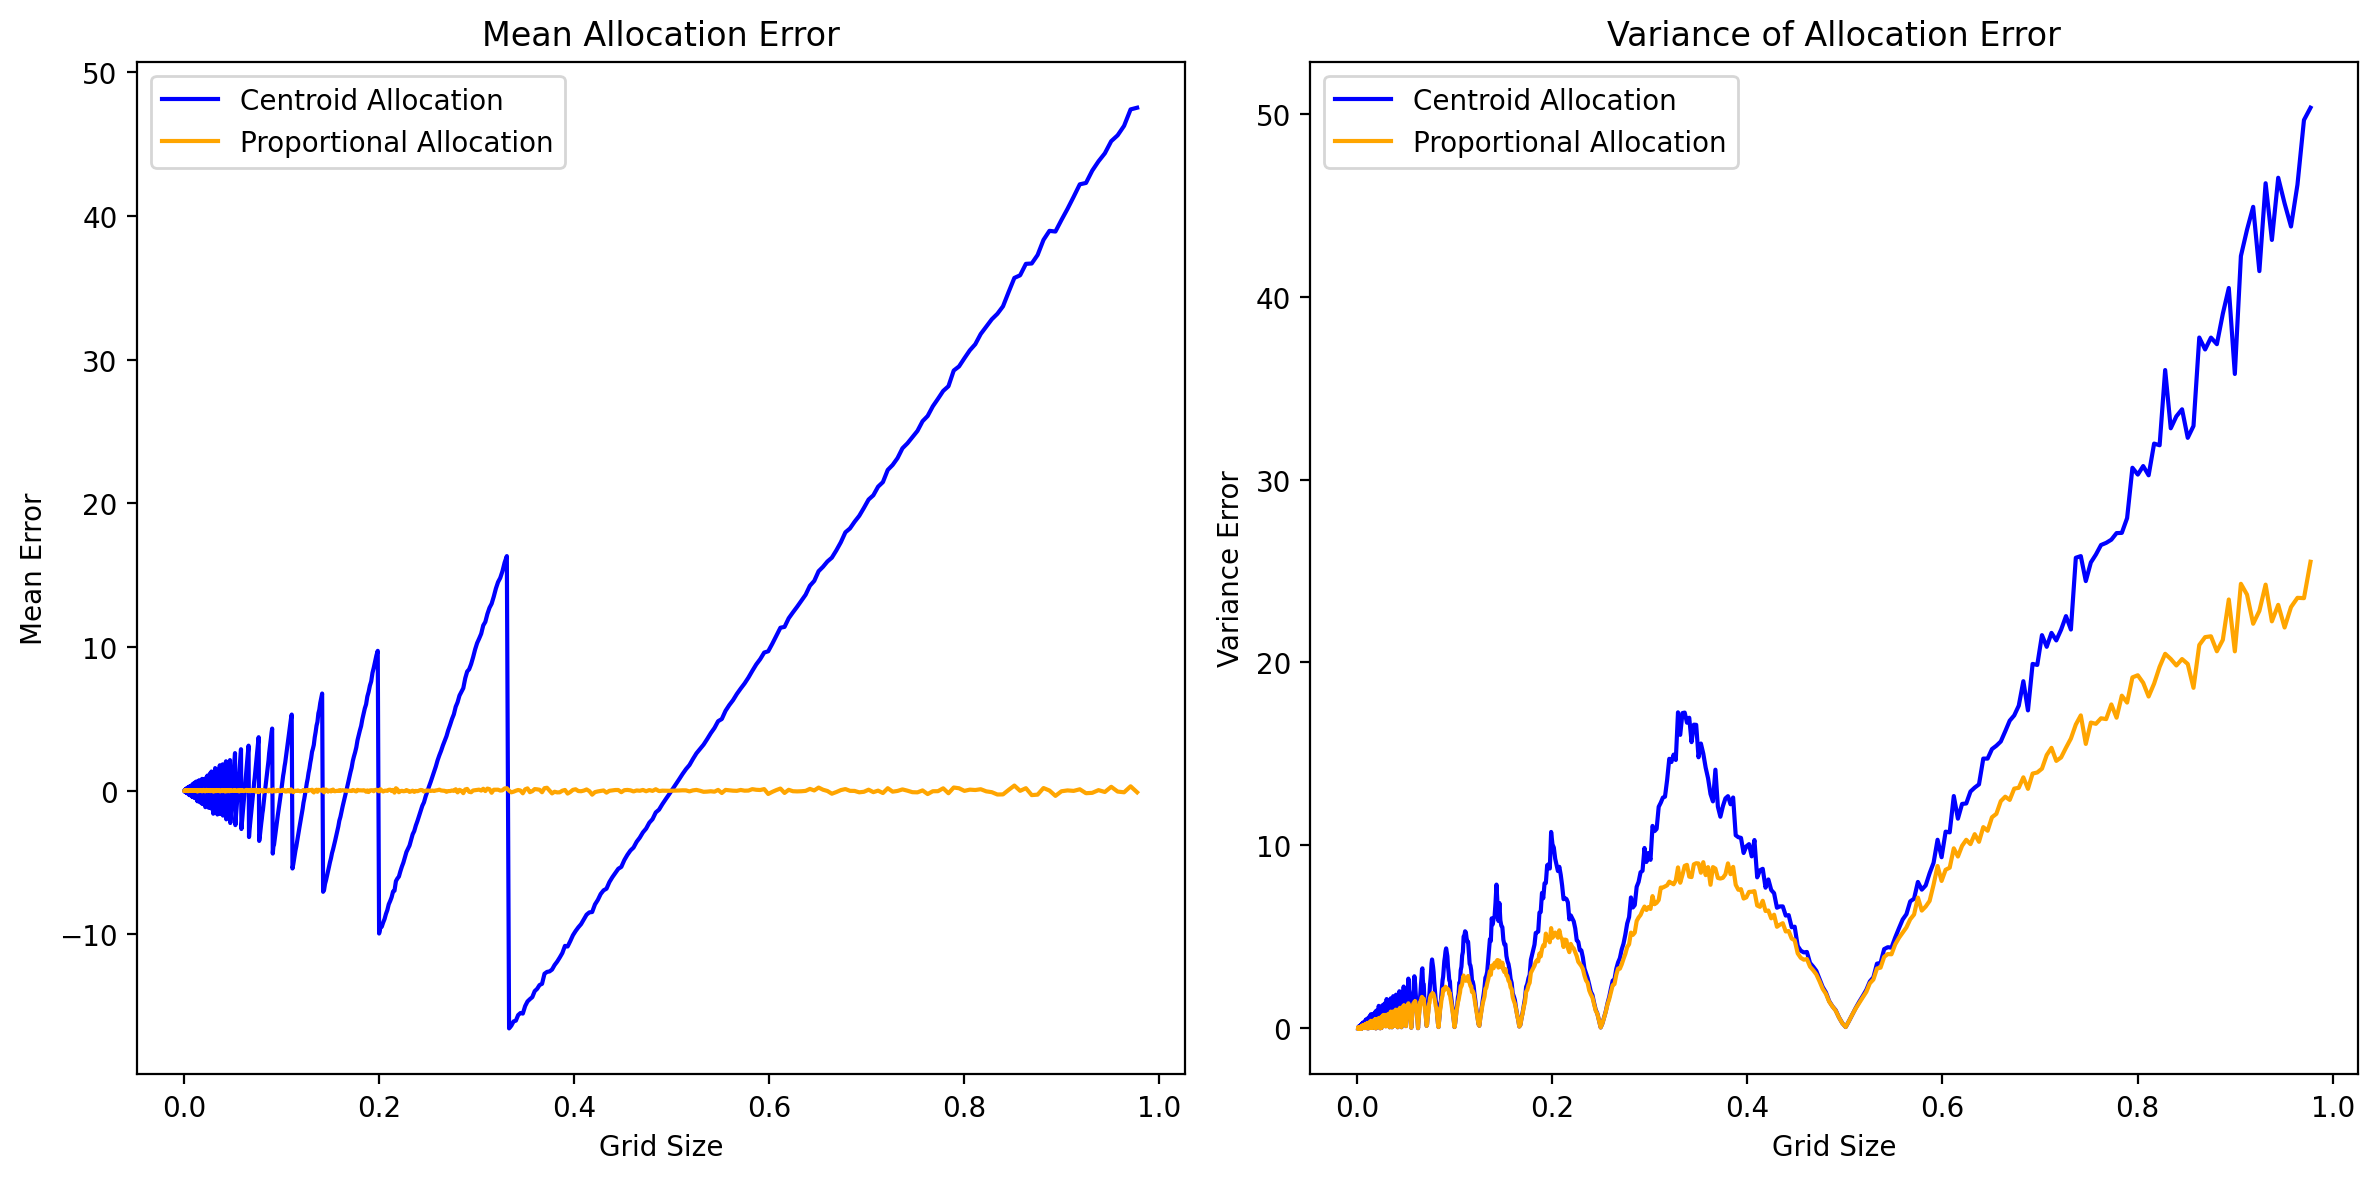

In [32]:
# Plot the resulting mean and variance of the estimates
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(dg, mean_estimate_centroid, label='Centroid Allocation', color='blue')
ax[0].plot(dg, mean_estimate_proportional, label='Proportional Allocation', color='orange')
ax[0].set_title('Mean Allocation Error')
ax[0].set_xlabel('Grid Size')
ax[0].set_ylabel('Mean Error')
ax[0].legend()
ax[1].plot(dg, var_estimate_centroid, label='Centroid Allocation', color='blue')
ax[1].plot(dg, var_estimate_proportional, label='Proportional Allocation', color='orange')
ax[1].set_title('Variance of Allocation Error')
ax[1].set_xlabel('Grid Size')
ax[1].set_ylabel('Variance Error')
ax[1].legend()
plt.tight_layout()
plt.show()